In [ ]:
# srun python src/fairness_train_timm-vggface2.py --config_path configs/mobilenetv3_large_100/config_mobilenetv3_large_100_CosFace_RMSpropTF.yaml


In [1]:
from comet_ml import Experiment
import argparse
from tqdm import tqdm
import os, sys
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import yaml
from head.metrics import CosFace
from loss.focal import FocalLoss
from utils.utils import separate_resnet_bn_paras, warm_up_lr, load_checkpoint, load_checkpoints_all, \
    schedule_lr, AverageMeter, accuracy
from utils.fairness_utils import evaluate
from utils.data_utils_balanced import prepare_data
from utils.utils_train import Network
import numpy as np
import pandas as pd
import random
import timm
from utils.utils import save_output_from_dict
from utils.utils_train import Network, get_head
from utils.fairness_utils import evaluate, add_column_to_file
from timm.optim import create_optimizer_v2, optimizer_kwargs
from timm.scheduler import create_scheduler
from timm.utils.model_ema import ModelEmaV2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device_ids=range(torch.cuda.device_count())
seed = 666
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


parser = argparse.ArgumentParser()

parser.add_argument('--config_path', type=str)

# args = parser.parse_args(['--config_path','../configs/mobilenetv3_large_100/config_mobilenetv3_large_100_CosFace_RMSpropTF.yaml'])
args = parser.parse_args(['--config_path','../configs_unified_lr/resnet50/config_resnet50_ArcFace_SGD_0.1_cosine.yaml'])
with open(args.config_path, "r") as ymlfile:
    options = yaml.load(ymlfile, Loader=yaml.FullLoader)
    print(options)
for key, value in options.items():
    setattr(args, key, value)
args.checkpoints_root = "Checkpoints/vggface2_train/"
args.default_train_root = '/cmlscratch/sdooley1/data/vggface2/train/'
args.default_test_root = '/cmlscratch/sdooley1/data/vggface2/test/'
args.demographics_file = '/cmlscratch/sdooley1/data/vggface2/vggface2_demographics.txt'
args.RFW_checkpoints_root = 'Checkpoints/vggface2_train/'
args.metadata_file = '/cmlscratch/sdooley1/timm_model_metadata.csv'
args.dataset = 'vggface2'
p_images = {
    args.groups_to_modify[i]: args.p_images[i]
    for i in range(len(args.groups_to_modify))
}
p_identities = {
    args.groups_to_modify[i]: args.p_identities[i]
    for i in range(len(args.groups_to_modify))
}
args.p_images = p_images
args.p_identities = p_identities

print("P identities: {}".format(args.p_identities))
print("P images: {}".format(args.p_images))


{'backbone': 'resnet50', 'batch_size': 64, 'bn_eps': None, 'bn_momentum': None, 'checkpoints_root': 'Checkpoints/Phase1B/', 'clip_grad': None, 'clip_mode': 'norm', 'comet_api_key': 'D1J58R7hYXPZzqZhrTIOe6GGQ', 'comet_workspace': 'samueld', 'cooldown_epochs': 10, 'dataset': 'CelebA', 'decay_epochs': 100, 'decay_rate': 0.1, 'default_test_root': '/cmlscratch/sdooley1/data/CelebA/Img/img_align_celeba_splits/val/', 'default_train_root': '/cmlscratch/sdooley1/data/CelebA/Img/img_align_celeba_splits/train/', 'demographics_file': '/cmlscratch/sdooley1/data/CelebA/CelebA_demographics.txt', 'dist_bn': 'reduce', 'drop': 0.0, 'drop_block': None, 'drop_connect': None, 'drop_path': None, 'epoch_repeats': 0.0, 'epochs': 100, 'file_name': 'timm_from-scratch.csv', 'file_name_ema': 'timm_from-scratch_ema.csv', 'gp': None, 'groups_to_modify': ['male', 'female'], 'head': 'ArcFace', 'input_size': 112, 'layer_decay': None, 'lr': 0.1, 'lr_cycle_decay': 0.5, 'lr_cycle_limit': 1, 'lr_cycle_mul': 1.0, 'lr_k_dec

In [2]:
dataloaders, num_class, demographic_to_labels_train, demographic_to_labels_test = prepare_data(args)
args.num_class = num_class

PREPARING TRAIN DATASET
Overall # of images for male available is 577106
# images selected for male is 577000
Overall # of images for female available is 612197
# images selected for female is 577000
Number of idx for male is 1617
Number of idx for female is 1617
PREPARING TEST DATASET
Overall # of images for male available is 69515
# images selected for male is 15300
Overall # of images for female available is 67644
# images selected for female is 15300
Number of idx for male is 202
Number of idx for female is 202
Len of train dataloader is 18031
Len of test dataloader is 479


In [3]:
run_name = os.path.splitext(os.path.basename(args.config_path))[0].replace('config_','')
output_dir = os.path.join('/cmlscratch/sdooley1/merge_timm/FR-NAS',args.checkpoints_root, run_name)
args.checkpoints_root = output_dir
# if not os.path.isdir(output_dir):
#     os.mkdir(output_dir)
output_dir = os.path.join('/cmlscratch/sdooley1/merge_timm/FR-NAS',args.RFW_checkpoints_root, run_name)
args.RFW_checkpoints_root = output_dir
# if not os.path.isdir(output_dir):
#     os.mkdir(output_dir)

# dataloaders, num_class, demographic_to_labels_train, demographic_to_labels_test = prepare_data(
#     args)
args.num_class = 7058
''' Model '''
if 'ghost' in args.backbone:
    backbone = timm.create_model(args.backbone,
                                 num_classes=0,
                                 pretrained=args.pretrained,
                                 drop_connect_rate=args.drop_connect,
                                 drop_path_rate=args.drop_path,
                                 drop_block_rate=args.drop_block,
                                 global_pool=args.gp,
                                 bn_momentum=args.bn_momentum,
                                 bn_eps=args.bn_eps,
                                 scriptable=args.torchscript,
                                 ).to(device)
elif 'mobilenet' in args.backbone:
    backbone = timm.create_model(args.backbone,
                                 num_classes=0,
                                 pretrained=args.pretrained,
                                 drop_path_rate=args.drop_path,
                                 drop_block_rate=args.drop_block,
                                 global_pool=args.gp,
                                 bn_momentum=args.bn_momentum,
                                 bn_eps=args.bn_eps,
                                 scriptable=args.torchscript,
                                 ).to(device)
else:
    backbone = timm.create_model(args.backbone,
                                 num_classes=0,
                                 pretrained=args.pretrained,
                                 drop_rate=args.drop,
                                 drop_connect_rate=args.drop_connect,
                                 drop_path_rate=args.drop_path,
                                 drop_block_rate=args.drop_block,
                                 global_pool=args.gp,
                                 bn_momentum=args.bn_momentum,
                                 bn_eps=args.bn_eps,
                                 scriptable=args.torchscript,
                                 ).to(device)

config = timm.data.resolve_data_config({}, model=backbone)
model_input_size = args.input_size

# get model's embedding size
meta = pd.read_csv(args.metadata_file)
embedding_size = int(
    meta[meta.model_name == args.backbone].feature_dim)
args.embedding_size= embedding_size

head = get_head(args)
train_criterion = FocalLoss(elementwise=True)
head,backbone= head.to(device), backbone.to(device)
backbone = nn.DataParallel(backbone)
####################################################################################################################
# ======= argsimizer =======#
model = Network(backbone, head)

optimizer = create_optimizer_v2(model, **optimizer_kwargs(cfg=args))
scheduler, num_epochs = create_scheduler(args, optimizer)

model_ema = None
if args.model_ema:
    # Important to create EMA model after cuda(), DP wrapper, and AMP but before DDP wrapper
    model_ema = ModelEmaV2(
        model, decay=args.model_ema_decay, device='cpu' if args.model_ema_force_cpu else None)
model, model_ema, optimizer, epoch, batch, checkpoints_model_root = load_checkpoint(
    args, model, model_ema, optimizer, dataloaders["train"], p_identities,
    p_images)
#model = nn.DataParallel(model)
model = model.to(device)
#print(model_ema

Checkpoint_Head_ArcFace_Backbone_resnet50_Opt_SGD_Dataset_CelebA_Epoch_
Found checkpoints for this model: ['Checkpoint_Head_ArcFace_Backbone_resnet50_Opt_SGD_Dataset_CelebA_Epoch_6.pth']
Loading Checkpoint '/cmlscratch/sdooley1/merge_timm/FR-NAS/Checkpoints/vggface2_train/resnet50_ArcFace_SGD_0.1_cosine/Checkpoint_Head_ArcFace_Backbone_resnet50_Opt_SGD_Dataset_CelebA_Epoch_6.pth'


In [4]:

backbone.eval()  # set to testing mode
head.eval()
'''For train data compute only multilabel accuracy'''
#             loss_train, acc_train, _, _, _, _,_,_,_,_ = evaluate(dataloaders.train, train_criterion, backbone,head, embedding_size,
#                                                 k_accuracy = False, multilabel_accuracy = True,
#                                                 demographic_to_labels = demographic_to_labels_train, test = False)
'''For test data compute only k-neighbors accuracy and multi-accuracy'''
k_accuracy = True
multilabel_accuracy = True
comp_rank = True

In [5]:
from utils.fairness_utils import intra_inter_variance

def l2_norm(input, axis = 1):
    # normalizes input with respect to second norm
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output

# def evaluate(dataloader, criterion, model, emb_size,  k_accuracy = False, multilabel_accuracy = False,
#              demographic_to_labels = None, test = True, rank = False):

dataloader, criterion, model, emb_size  = dataloaders["test"], train_criterion, model, embedding_size,
k_accuracy=k_accuracy
multilabel_accuracy=multilabel_accuracy
demographic_to_labels=demographic_to_labels_test
test=True
rank=comp_rank

loss = {k:torch.tensor(0.0) for k in demographic_to_labels.keys()}
acc = {k:torch.tensor(0.0) for k in demographic_to_labels.keys()}
count = {k:torch.tensor(0.0) for k in demographic_to_labels.keys()}
acc_k = {k:torch.tensor(0.0) for k in demographic_to_labels.keys()}
intra = {k:torch.tensor(0.0) for k in demographic_to_labels.keys()}
inter = {k:torch.tensor(0.0) for k in demographic_to_labels.keys()}
angles_intra, angles_inter, correct = 0, 0, 0

#backbone.eval()
#if multilabel_accuracy:
#    head.eval()
model.eval()
# figure out embedding size
if emb_size is None:
    inputs, _, _ = next(iter(dataloader))
    x = torch.randn(inputs.shape).to(device)
    emb_size = backbone(x).shape[1]


feature_matrix = torch.empty(0, emb_size)
labels_all = []
indices_all = []
demographic_all = []
predicted_all = []

for inputs, labels, sens_attr, indices in tqdm(iter(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device).long()
    labels_all = labels_all + labels.cpu().tolist()
    indices_all = indices_all + indices.cpu().tolist()
    sens_attr = np.array(sens_attr)
    with torch.no_grad():

        if multilabel_accuracy:
            outputs, loss_g= model(inputs, labels)
            loss_value = criterion(outputs, labels)+loss_g

            # add sum of losses for female and male images
            for k in loss.keys():
                loss[k] += loss_value[sens_attr == k].sum().cpu()

            # multiclass accuracy
            _, predicted = outputs.max(1)
            predicted_all = predicted_all + predicted.cpu().tolist()



            for k in acc.keys():
                acc[k] +=  predicted[sens_attr == k].eq(labels[sens_attr == k]).sum().cpu().item()

            for k in count.keys():
                count[k] += sum(sens_attr == k)

        if k_accuracy:
            #need to build feature matrix
            inputs_flipped = torch.flip(inputs, [3])
            try:
                embed = model.module.backbone(inputs) + model.module.backbone(inputs_flipped)
            except AttributeError:
                embed = model.backbone(inputs) + model.backbone(inputs_flipped)
            features_batch = l2_norm(embed)
            feature_matrix = torch.cat((feature_matrix, features_batch.detach().cpu()), dim = 0)

            demographic_all = demographic_all + sens_attr.tolist()


if multilabel_accuracy:
    for k in acc.keys():
        acc[k] = acc[k]/count[k].item()
        loss[k] = loss[k]/count[k].item()

if k_accuracy and test:
    intra, inter, angles_intra, angles_inter, class_centers = intra_inter_variance(feature_matrix, torch.tensor(labels_all), demographic_to_labels)
#     acc_k, correct, nearest_id, rank = predictions(feature_matrix, torch.tensor(labels_all), demographic_to_labels, feature_matrix, torch.tensor(labels_all), np.array(demographic_all), rank)

if k_accuracy and not test:
    m_labels = np.random.choice(demographic_to_labels['male'], 30)
    f_labels = np.random.choice(demographic_to_labels['female'], 30)
    m_idx = [idx for idx, label in enumerate(labels_all) if label in m_labels]
    f_idx = [idx for idx, label in enumerate(labels_all) if label in f_labels]

    test_labels = torch.cat((torch.tensor(labels_all)[m_idx], torch.tensor(labels_all)[f_idx]), dim=0)
    test_features = torch.cat((feature_matrix[m_idx], feature_matrix[f_idx]), dim=0)
    test_demographic = np.take(np.array(demographic_all), m_idx).tolist() +  np.take(np.array(demographic_all), f_idx).tolist()

#     intra, inter, angles_intra, angles_inter, class_centers = intra_inter_variance(feature_matrix, torch.tensor(labels_all), demographic_to_labels)
#     acc_k, correct, nearest_id, rank = predictions(feature_matrix, torch.tensor(labels_all), demographic_to_labels, test_features, torch.tensor(test_labels), np.array(test_demographic))


# return loss, acc, acc_k, predicted_all, intra, inter, angles_intra, angles_inter, correct, nearest_id, labels_all, indices_all, demographic_all, rank


100%|██████████| 479/479 [00:54<00:00,  8.77it/s]


In [6]:
def l2_dist(feature_matrix, test_features):
    ''' computing distance matrix '''
    return torch.cdist(test_features, feature_matrix)

# def predictions(feature_matrix, labels, demographic_to_labels, test_features, test_labels, test_demographic, rank):

feature_matrix, labels, demographic_to_labels, test_features, test_labels, test_demographic, rank = feature_matrix, torch.tensor(labels_all), demographic_to_labels, feature_matrix, torch.tensor(labels_all), np.array(demographic_all), rank
def process_row(row, distances, labels_np):
    """ 
    given a row where the row is a list of image ids where this list increases
    in distance in the featue space where the first point is the refernce point.
    returns the index of the closest point with the same label, if no such point, returns -1
    """
    base_label = labels_np[row[0]]
    n_img = 1
    n_id = 1
    ids = set()
    while n_img < row.shape[0]:
        # add this id to the set of 
        ids.add(labels_np[row[n_img]])
        if labels_np[row[n_img]] == base_label:
            return n_img-1, len(list(ids))-1, distances[1], distances[n_img]
        n_img+=1
    return -1,-1,-1,-1

# if rank is true, then compute the rank of the prediction
if rank == True:
    k = test_features.shape[0]
# otherwise, just compute the accuracy
else:
    k = 2

dist_matrix =  l2_dist(feature_matrix, test_features)
labels_np = labels.numpy()
distances, inc_dist = torch.topk(dist_matrix, dim=1, k = k, largest = False)
nearest_same_label = torch.tensor([process_row(row[0],row[1], labels_np) for row in zip(inc_dist,distances)])

correct = (nearest_same_label[:,0] == 0).long()
nearest_id = inc_dist[:,1].apply_(lambda x: labels_np[x])
acc_k = {k:0 for k in demographic_to_labels.keys()}
for k in acc_k.keys():
    acc_k[k] = (correct[test_demographic == k]).float().mean()

# return acc_k, correct, nearest_id, nearest_same_label


In [46]:
nearest_same_label = torch.tensor([process_row(row[0],row[1], labels_np) for row in zip(inc_dist,distances)])

In [55]:
nearest_same_label[nearest_same_label[:,2]<0.05].shape[0]

1001

In [22]:
import time
x = 0.12
dist2closest_point = nearest_same_label[:,2]
dist2closest_same_id = nearest_same_label[:,3]

fnir = nearest_same_label[dist2closest_same_id>x].shape[0]/nearest_same_label.shape[0]
fpnir = nearest_same_label[torch.logical_and(dist2closest_point <= x, dist2closest_same_id > x)].shape[0]

2149

In [40]:
fpir = np.array([])
fnir = np.array([])
dist2closest_point = nearest_same_label[:,2]
dist2closest_same_id = nearest_same_label[:,3]
for x in np.arange(0,max(nearest_same_label[:,3]),.001)[1:]:
    fpir = np.append(fpir,nearest_same_label[dist2closest_same_id>x].shape[0])
    fnir = np.append(fnir,nearest_same_label[torch.logical_and(dist2closest_point <= x, 
                                                               dist2closest_same_id > x)].shape[0])

In [66]:
pd.DataFrame(np.insert(nearest_same_label.numpy(), 0, indices_all, axis=1), 
             columns=["index","nearest_by_img","nearest_by_id","closest_point","closest_same_id"]).to_pickle()

<bound method NDFrame.to_pickle of          index  nearest_by_img  nearest_by_id  closest_point  closest_same_id
0          0.0             0.0            0.0       0.042559         0.042559
1          1.0             0.0            0.0       0.050293         0.050293
2          2.0             0.0            0.0       0.046402         0.046402
3          3.0             0.0            0.0       0.105628         0.105628
4          4.0             0.0            0.0       0.054323         0.054323
...        ...             ...            ...            ...              ...
30595  30595.0             0.0            0.0       0.099167         0.099167
30596  30596.0             0.0            0.0       0.025957         0.025957
30597  30597.0            10.0            8.0       0.125220         0.153907
30598  30598.0             0.0            0.0       0.082723         0.082723
30599  30599.0             0.0            0.0       0.077910         0.077910

[30600 rows x 5 columns]>

<IPython.core.display.Javascript object>


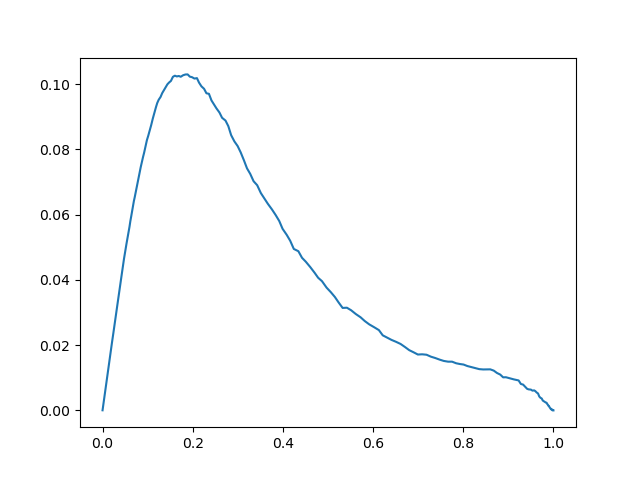

In [49]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot(fpir/30600,fnir/30600)

In [99]:
nearest_same_label[:,0].apply_(lambda x: foo[0,x])

TypeError: tuple indices must be integers or slices, not tuple

In [69]:
foo = torch.topk(dist_matrix, dim=1, k = 30600, largest = False)

In [92]:
[labels_np[x] for x in foo[1][1][:20]]

[81,
 388,
 44,
 22,
 180,
 94,
 154,
 300,
 323,
 255,
 208,
 380,
 75,
 180,
 81,
 230,
 59,
 367,
 299,
 117]

In [83]:
foo[1][5].sum()

tensor(468164700)

In [79]:
sum(range(30600))

468164700

In [ ]:
loss, acc, acc_k, predicted_all, intra, inter, angles_intra, angles_inter, correct, nearest_id, labels_all, indices_all, demographic_all, rank = evaluate(
    dataloaders["test"],
    train_criterion,
    model,
    embedding_size,
    k_accuracy=k_accuracy,
    multilabel_accuracy=multilabel_accuracy,
    demographic_to_labels=demographic_to_labels_test,
    test=True, rank=comp_rank)
if model_ema is not None:
    loss_ema, acc_ema, acc_k_ema, predicted_all_ema, intra_ema, inter_ema, angles_intra_ema, angles_inter_ema, correct_ema, nearest_id_ema, labels_all_ema, indices_all_ema, demographic_all_ema, rank = evaluate(
            dataloaders["test"],
            train_criterion,
            model_ema.module,
            embedding_size,
            k_accuracy=k_accuracy,
            multilabel_accuracy=multilabel_accuracy,
            demographic_to_labels=demographic_to_labels_test,
            test=True, rank=comp_rank)
# save outputs
# save outputs
kacc_df, multi_df, rank_by_image_df, rank_by_id_df = None, None, None, None
if k_accuracy:
    kacc_df = pd.DataFrame(np.array([list(indices_all),
                                     list(nearest_id)]).T,
                           columns=['ids','epoch_'+str(epoch)]).astype(int)
if multilabel_accuracy:
    multi_df = pd.DataFrame(np.array([list(indices_all),
                                      list(predicted_all)]).T,
                            columns=['ids','epoch_'+str(epoch)]).astype(int)
if comp_rank:
    rank_by_image_df = pd.DataFrame(np.array([list(indices_all),
                                      list(rank[:,0])]).T,
                            columns=['ids','epoch_'+str(epoch)]).astype(int)
    rank_by_id_df = pd.DataFrame(np.array([list(indices_all),
                                      list(rank[:,1])]).T,
                            columns=['ids','epoch_'+str(epoch)]).astype(int)

100%|██████████| 2110/2110 [05:50<00:00,  6.02it/s]


In [3]:

''' Model '''
backbone = timm.create_model(args.backbone_name, 
                             num_classes=0,
                             pretrained=args.pretrained).to(device)
config = timm.data.resolve_data_config({}, model=backbone)
model_input_size = config['input_size']

# get model's embedding size
meta = pd.read_csv('/cmlscratch/sdooley1/timm_model_metadata.csv')
embedding_size = int(
    meta[meta.model_name == args.backbone].feature_dim)
args.embedding_size= embedding_size




head = get_head(args)
train_criterion = FocalLoss(elementwise=True)
head,backbone= head.to(device), backbone.to(device)
backbone = nn.DataParallel(backbone)
####################################################################################################################
# ======= argsimizer =======#
model = Network(backbone, head)

optimizer = create_optimizer_v2(model, **optimizer_kwargs(cfg=args))

model_ema = None
model, model_ema, optimizer, epoch, batch, checkpoints_model_root = load_checkpoint(
    args, model, model_ema, optimizer, dataloaders["train"], p_identities,
    p_images)
#model = nn.DataParallel(model)
model = model.to(device)

AttributeError: 'Namespace' object has no attribute 'backbone_name'

In [17]:
demographic_to_labels = demographic_to_labels_train
loss = {k:torch.tensor(0.0) for k in demographic_to_labels.keys()}
acc = {k:torch.tensor(0.0) for k in demographic_to_labels.keys()}
count = {k:torch.tensor(0.0) for k in demographic_to_labels.keys()}
acc_k = {k:torch.tensor(0.0) for k in demographic_to_labels.keys()}
intra = {k:torch.tensor(0.0) for k in demographic_to_labels.keys()}
inter = {k:torch.tensor(0.0) for k in demographic_to_labels.keys()}
angles_intra, angles_inter, correct = 0, 0, 0

#backbone.eval()
#if multilabel_accuracy:
#    head.eval()
model.eval()
# figure out embedding size
emb_size = embedding_size
dataloader = dataloaders['test']
if emb_size is None:
    inputs, _, _ = next(iter(dataloader))
    x = torch.randn(inputs.shape).to(device)
    emb_size = backbone(x).shape[1]


feature_matrix = torch.empty(0, emb_size)
labels_all = []
indices_all = []
demographic_all = []
predicted_all = []

for inputs, labels, sens_attr, indices in tqdm(iter(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device).long()
    labels_all = labels_all + labels.cpu().tolist()
    indices_all = indices_all + indices.cpu().tolist()
    sens_attr = np.array(sens_attr)
    with torch.no_grad():

        if True:
            #need to build feature matrix
            inputs_flipped = torch.flip(inputs, [3])
            try:
                embed = model.module.backbone(inputs) + model.module.backbone(inputs_flipped)
            except AttributeError:
                embed = model.backbone(inputs) + model.backbone(inputs_flipped)
            features_batch = l2_norm(embed)
            feature_matrix = torch.cat((feature_matrix, features_batch.detach().cpu()), dim = 0)

            demographic_all = demographic_all + sens_attr.tolist()


AttributeError: 'NoneType' object has no attribute 'keys'

In [7]:
feature_matrix, labels, demographic_to_labels, test_features, test_labels, test_demographic = feature_matrix, torch.tensor(labels_all), demographic_to_labels, feature_matrix, torch.tensor(labels_all), np.array(demographic_all)



In [8]:
dist_matrix =  l2_dist(feature_matrix, feature_matrix)

In [11]:
acc_k = {k:0 for k in demographic_to_labels.keys()}
nearest_neighbors = torch.topk(dist_matrix, dim=1, k = 2, largest = False)[1][:,1]
n_images = dist_matrix.shape[0]
correct = torch.zeros(test_labels.shape)
nearest_id = torch.zeros(test_labels.shape)

t = time.time()
for img in range(n_images):
    nearest_label = labels[nearest_neighbors[img]].item()
    nearest_id[img] = nearest_label
    label_img = test_labels[img].item()
    if label_img == nearest_label:
        correct[img] = 1
print(time.time()-t)
for k in acc_k.keys():
    acc_k[k] = (correct[test_demographic == k]).mean()

# acc_k, 
# correct = torch.tensor(just_one + 1)
# nearest_id = torch.tensor(df[1].apply(lambda x: labels_np[x]))

0.2038564682006836


In [25]:
rank = True
def process_row(row, labels_np):
    """ 
    given a row where the row is a list of image ids where this list increases
    in distance in the featue space where the first point is the refernce point.
    returns the index of the closest point with the same label, if no such point, returns -1
    """
    base_label = labels_np[row[0]]
    n_img = 1
    n_id = 1
    ids = set()
    while n_img < row.shape[0]:
        # add this id to the set of 
        ids.add(labels_np[row[n_img]])
        if labels_np[row[n_img]] == base_label:
            return n_img-1, len(list(ids))-1
        n_img+=1
    return -1,-1

# if rank is true, then compute the rank of the prediction
if rank == True:
    k = test_features.shape[0]
# otherwise, just compute the accuracy
else:
    k = 2

dist_matrix =  l2_dist(feature_matrix, test_features)
labels_np = labels.numpy()
inc_dist = torch.topk(dist_matrix, dim=1, k = k, largest = False)[1]
nearest_same_label = torch.tensor([process_row(row, labels_np) for row in inc_dist])

correct = (nearest_same_label[:,0] == 0).long()
nearest_id = inc_dist[:,1].apply_(lambda x: labels_np[x])
acc_k = {}
for k in acc_k.keys():
    acc_k[k] = (correct[test_demographic == k]).mean()

return acc_k, correct, nearest_id, nearest_same_label


In [26]:
nearest_same_label[nearest_same_label[:,0] != 0]

tensor([[  7,   7],
        [279, 107],
        [  1,   1],
        ...,
        [  2,   2],
        [  7,   7],
        [303, 162]])

In [46]:
sum((entire == 0).long() == just_one + 1)

tensor(15272)

In [47]:
entire

tensor([0, 0, 0,  ..., 0, 0, 0])

In [ ]:
entire[entire > 0]

In [ ]:
just_one[just_one == -1]

In [ ]:
df = pd.DataFrame(desc_dist.numpy())

In [ ]:
df.apply(lambda x: labels_np[x])

In [ ]:
def process_row(row):
    base_label = labels_np[row[0]]
    i = 1
    while i < row.shape[0]:
        if labels_np[row[i]] == base_label:
            return i-1
        i+=1
    return i-1
df.apply(lambda row : process_row(row), axis = 1)

In [ ]:
labels

In [ ]:
desc_dist.shape

In [ ]:
desc_dist.apply_(lambda x: labels[x])

In [31]:
foo = ['Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_80.pth', 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_20.pth', 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_101.pth', 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_60.pth', 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_40.pth', 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_100.pth']

foo.sort(key = lambda x: int(x.split('Epoch_')[1].split('.')[0]))
foo

['Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_20.pth',
 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_40.pth',
 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_60.pth',
 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_80.pth',
 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_100.pth',
 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_101.pth']

In [34]:
list(filter(lambda x: int(x.split('Epoch_')[1].split('.')[0]) in [20,40,60,80,100], ckpts ))

['Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_20.pth',
 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_40.pth',
 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_60.pth',
 'Checkpoint_Head_CosFace_Backbone_mobilenetv3_large_100_Opt_AdamW_Dataset_CelebA_Epoch_80.pth']

In [7]:
k_accuracy = True
multilabel_accuracy = True
comp_rank = True
loss, acc, acc_k, predicted_all, intra, inter, angles_intra, angles_inter, correct, nearest_id, labels_all, indices_all, demographic_all, rank = evaluate(
    dataloaders["test"],
    train_criterion,
    model,
    embedding_size,
    k_accuracy=k_accuracy,
    multilabel_accuracy=multilabel_accuracy,
    demographic_to_labels=demographic_to_labels_test,
    test=True, rank=comp_rank)

rank_by_id = pd.DataFrame(np.array([list(indices_all),
                                    list(rank[:,1])]).T,
                          columns=['ids','rank_by_id']).astype(int)

metadata = pd.read_csv('../Checkpoints/val_identities_gender-expression_seed_222.csv')
df = rank_by_id.merge(metadata)

def rank_ratio_func(df):
    # calculate the ratio of ranks
    data = {}
    for g,g_df in df.groupby('gender_expression'):
        data[g] = (g_df['rank_by_id']).sum(axis=0)/g_df.shape[0]
    return data['male']/data['female']

rank_ratio_func(df)

100%|██████████| 62/62 [00:12<00:00,  4.82it/s]


In [9]:
labels_all

[59,
 59,
 59,
 99,
 99,
 99,
 162,
 162,
 162,
 144,
 144,
 144,
 54,
 54,
 54,
 300,
 300,
 300,
 272,
 272,
 272,
 324,
 324,
 324,
 430,
 430,
 430,
 306,
 306,
 306,
 166,
 166,
 166,
 72,
 72,
 72,
 238,
 238,
 238,
 78,
 78,
 78,
 49,
 49,
 49,
 7,
 7,
 7,
 313,
 313,
 313,
 308,
 308,
 308,
 218,
 218,
 218,
 410,
 410,
 410,
 415,
 415,
 415,
 148,
 148,
 148,
 179,
 179,
 179,
 377,
 377,
 377,
 277,
 277,
 277,
 359,
 359,
 359,
 31,
 31,
 31,
 4,
 4,
 4,
 285,
 285,
 285,
 261,
 261,
 261,
 370,
 370,
 370,
 217,
 217,
 217,
 212,
 212,
 212,
 139,
 139,
 139,
 295,
 295,
 295,
 5,
 5,
 5,
 50,
 50,
 50,
 298,
 298,
 298,
 284,
 284,
 284,
 13,
 13,
 13,
 251,
 251,
 251,
 157,
 157,
 157,
 223,
 223,
 223,
 150,
 150,
 150,
 289,
 289,
 289,
 21,
 21,
 21,
 45,
 45,
 45,
 53,
 53,
 53,
 371,
 371,
 371,
 25,
 25,
 25,
 227,
 227,
 227,
 279,
 279,
 279,
 381,
 381,
 381,
 378,
 378,
 378,
 386,
 386,
 386,
 192,
 192,
 192,
 374,
 374,
 374,
 143,
 143,
 143,
 229,
 229,
 

In [8]:
rank_ratio_func(df)

0.8374023273751635